In [10]:
import numpy as np
import scipy as sp
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.integrate import quad

class Simaan():
    def __init__(self):
        #Simulation Time
        self.start_t = 0 
        self.passo = 0.0001
        self.end_t = 10
 
        #Uses the already created Time Scale
        self.T = list(np.arange(self.start_t,self.end_t,self.passo)) #
        self.n = len(self.T)
        
        #Cardiovascular System
        self.HR = 100
        self.Emax = 0.8 #Amplitude da função elastância
        self.Emin = 0.06
        self.tc = 60/self.HR #Intervalo de tempo referente à duração de um ciclo cardíaco
        self.t_max = 0.2 + 0.15*self.tc; #Tempo máximo da duração de um ciclo cardíaco
        
        self.En = self.elastance(self.T) #Elastância normalizada
        self.E = (self.Emax-self.Emin)*self.En + self.Emin
        self.Ea = self.En*self.Emax
        
        #Cardiovascular System Model Parameters (from Simaan2009)
 
        #Valores de resistores,fontes e bobina 
        self.Rs  = 1.0000 #Resistência sistêmica vascular
        self.Rm  = 0.0050 #Resistência da válvula mitral
        self.Ra  = 0.0060 #Resistência da válvula aorta
        self.Rc  = 0.0398 #Characteristics Resistance
        self.Cae = 4.4000 #Elastância no átrio esquerdo
        self.Cs  = 1.3300 #Elastância sistêmica
        self.Cao = 0.0800 #Elastância na aorta
        self.Ls  = 0.0005 #Inertância sanguinea na aorta
        self.Vo = 15 #Pressão Inicial
        self.Vd = 5
        self.dV = self.Vo - self.Vd
 
        #Alocando
        self.Pao = np.zeros_like(self.T) #Pressão na aorta
        self.Qa  = np.zeros_like(self.T) #Fluxo na aorta
        self.Vve = np.zeros_like(self.T) #Volume no ventrículo esquerdo
        self.Pas = np.zeros_like(self.T) #Pressão na aorta sistêmica
        self.Pae = np.zeros_like(self.T) #Pressão no átrio esquerdo
        self.Pve = np.zeros_like(self.T) #Pressão no ventrículo esquerdo
        self.Dm_ = np.zeros_like(self.T) 
        self.Da_ = np.zeros_like(self.T) 
 
        #Initial Conditions
        self.Pao[0] = 90
        self.Qa[0]  = 0
        self.Vve[0] = 111
        self.Pas[0] = 90
        self.Pae[0] = 5
        self.Pve[0] = self.E[0]* (self.Vve[0] - self.Vo) 
 
        #x = [x1 x2 x3 x4 x5]
        self.x = np.transpose([self.Pao[0], self.Qa[0], self.Vve[0], self.Pas[0], self.Pae[0]])
 
        #Estado inicial dos diodos
        self.Dm = 0
        self.Da = 0

        #ECG
        self.TH = []
        self.signal_P = 0
        self.signal_Q = 0
        self.signal_R = 0
        self.signal_S = 0
        self.signal_T = 0
        self.bi = [] #Largura da equação Gaussiana
        self.w = 0 #É a velocidade angular da trajetória a medida que se move em torno do ciclo limite

        self.xECG = []
        self.yECG = []
        self.zECG = []

    def elastance(self, t):
        tn = np.asarray(t)%self.tc/self.t_max;
        En = 1.55 * np.power(np.asarray(tn)/.7, 1.9) / (1 + np.power(np.asarray(tn)/.7, 1.9)) / (1 + np.power(np.asarray(tn)/1.17, 21.9))
        return En

    def setECG(self):
        self.TH = np.array([-1/3, -1/12, 0, 1/12, 1/2])*np.pi
        self.signal_P = 1.20
        self.signal_Q = -5.00
        self.signal_R = 25.0
        self.signal_S = -7.5
        self.signal_T = 0.75
        self.bi = [0.25, 0.10, 0.50, 0.10, 0.40]
        self.w = (2*np.pi)/self.tc #É a velocidade angular da trajetória a medida que se move em torno do ciclo limite

        [self.xECG, self.yECG, self.zECG] = ECG_McSharry(self.passo, self.n, self.TH, self.signal_P, self.signal_Q, self.signal_R, self.signal_S, self.signal_T, self.bi, self.w)
        
 
    def att(self, index, vad):
       self.x =  runkut4(model.passo, A, model.x, B,i)

       #CVS VARIABLES
    
       self.Pao[index] =  self.x[0]
       self.Qa[index]  =  self.x[1]
       self.Vve[index] =  self.x[2]
       self.Pas[index] =  self.x[3]
       self.Pae[index] =  self.x[4]
       self.Pve[index] = self.E[index] * (self.Vve[index] - self.Vo)

       #VAD VARIABLES
       vad.Ri[index] = vad.Ri[index] + np.exp(-0.25*self.Vve[index])

In [11]:
class VAD():
  def __init__(self,model):


    self.max_vol = 100
    self.Vd_vad = 107
    self.Vd_vad_v = list(np.zeros_like(model.T))
    self.Vd_vad_v[0] = self.Vd_vad
   
    self.V_vad = 110

    self.V_total = 370 #Volume total de sangue

    #Valores humanos para a cânula
    self.DAV_cannula_length_out = 32
    self.DAV_cannula_length_in = 24
    self.DAV_cannula_area = (0.9**2)*np.pi
    self.DAV_rho_blood = 1

    self.DAV_length = 10 #cm
    self.DAV_area = 5 #cm

    #self.Ri = list(np.zeros_like(model.T))
    #self.Ri[0] = np.exp(-0.25*model.Vve[0])
    self.Ri = 0.15
    self.Ri0 = 0.15
    self.Ro = 0.05

    self.Li = 1.75*(9/4)*(self.DAV_rho_blood*self.DAV_cannula_length_in)/(1359.5*self.DAV_cannula_area)
    self.Lo = (self.DAV_rho_blood*self.DAV_cannula_length_out)/(1359.5*self.DAV_cannula_area)

    self.Lp = (9/4)*(self.DAV_rho_blood*self.DAV_length)/(1359.5*self.DAV_area) #A ausência desse indutor não altera o comportamento do DAV


    self.Rp = 0.05
    self.Cp = 2.0
    self.Rd = 0.01
    self.Cd = 4.0


    self.ts_DAV = 0.50 #Tempo de duração da sistole do DAV
    self.t_eject = (model.tc*self.ts_DAV)/model.passo # Ejection time for VAD in fill-to-empty operation
    self.t_eject_c = self.t_eject

    self.Pf = 0

    self.Qi = 0
    self.Qo = 0

    self.deltaS = list(np.zeros_like(model.T))
    self.deltaPVAD = list(np.zeros_like(model.T))
    self.gammad = list(np.zeros_like(model.T))


    self.x = [self.Qi, self.Qo, self.V_vad]
    self.xdot = [0,0,0,0,0,0,0,0]

    self.deltaPVAD = list(np.zeros_like(model.T))
    self.deltaPVAD[0] = 0
    self.deltaS[0] = 1
    self.gammad[0] = 1 - 0.25

    self.Pt = 0
    self.Px = 0
    self.Pex = 0
    self.Pex2 = 0
    self.Pd = 0
    self.Pee = list(np.zeros_like(model.T))
    self.Pe = list(np.zeros_like(model.T))
    self.Pe[0] = 90
    self.Pee[0] = self.Pe[0]
    self.Pp = (self.V_vad - self.Vd_vad)/self.Cp
    self.Pdrive = 0
    self.Pexternal = self.Pd

    self.Di = 0
    self.Do = 0

    self.open = 1

    

    self.Vr = model.Cae*model.Pae[0]
    self.Vp = model.Cs*model.Pas[0]
    self.Vao = model.Cao*model.Pao[0]

    self.Pp = (self.V_vad - self.Vd_vad)/self.Cp

    model.Vve[0] = self.V_total - self.V_vad - self.Vr - self.Vp - self.Vao
    model.Pve[0] = (model.Vve[0] - model.Vd)*(model.Ea[0] + model.Emin) - model.Emin*model.dV

    self.delay_in  = -100
    self.delay_out = -100

    self.mode = 0

    #Reference
    self.mPao_ref = 90
    self.mPao_v = list(np.zeros_like(model.T))
    self.mPao_v[0] = self.mPao_ref

    self.mPao_ref_v = list(np.zeros_like(model.T))
    self.mPao_ref_v[0] = self.mPao_ref

    self.aux = []
    self.mPao = 80

    self.ip = 0
    self.ig = 0

    self.ea = 0
    self.e = list(np.zeros_like(model.T))
    self.e[0] = 0
    self.ierror = 0
    self.ierror_max = 100
    self.Kp = 1
    self.Ki = 4

    self.Kd = 0.5
    self.N = 8


    self.b0 = self.Kp*(1+model.n) + self.Ki*(1+model.n) + self.Kd*model.n
    self.b1 = -(self.Kp*(2+model.n) + self.Ki + 2*self.Kd*model.n)
    self.b2 = self.Kp + self.Kd*model.n
    self.a0 = 1 + model.n
    self.a1 = -(2+model.n)
    self.a2 = 1

In [12]:
def ECG_McSharry(Ts,N,TH,aiP,aiQ,aiR,aiS,aiT,bi,w):
    T = np.arange(N)

    xECG = list(np.zeros_like(T))
    yECG = list(np.zeros_like(T))
    zECG = list(np.zeros_like(T))

    xECG[0] = -1 
    
    x = [xECG[0], yECG[0], zECG[0]]

    for i in range(N-1):
      x = runkut4_ECG(Ts,x,TH,aiP,aiQ,aiR,aiS,aiT,bi,w)
      xECG[i+1] = x[0]
      yECG[i+1] = x[1]
      zECG[i+1] = x[2]
      
    return [xECG, yECG, zECG]

    
def runkut4_ECG(passo,x,TH,aiP,aiQ,aiR,aiS,aiT,bi,w):

    x = np.array(x)

    xdot = equacoes_ECG(x,TH,aiP,aiQ,aiR,aiS,aiT,bi,w)
    kx1 = passo*np.array(xdot)

    x1 = x + 0.5*np.array(kx1)

    xdot = equacoes_ECG(x1,TH,aiP,aiQ,aiR,aiS,aiT,bi,w)
    kx2 = passo*np.array(xdot)
    
    x1 = x + 0.5*np.array(kx2)
    xdot = equacoes_ECG(x1,TH,aiP,aiQ,aiR,aiS,aiT,bi,w)
    kx3 = passo*np.array(xdot)
 
    x1 = x + kx3
    xdot = equacoes_ECG(x1,TH,aiP,aiQ,aiR,aiS,aiT,bi,w)
    kx4 = passo*np.array(xdot)
 
    value = np.asarray(x + np.array((kx1 + 2*np.array(kx2) + 2*np.array(kx3) + kx4))/6)

    return value

def equacoes_ECG(x,TH,aiP,aiQ,aiR,aiS,aiT,bi,w):
    k = 0

    alpha = 1-np.sqrt(np.power(x[0],2) + np.power(x[1],2))
    th = np.arctan2(x[1], x[0])
    ai = [aiP, aiQ, aiR, aiS, aiT]
    xdot = [[0],[0],[0]]

    for i in range(5):
      k = k - (ai[i]*(th-TH[i])*np.exp( - (np.power(th-TH[i],2)/ (2*np.power(bi[i],2)))))
      

    xdot[0] = alpha*np.array(x[0]) - w*np.array(x[1])
    xdot[1] = w*np.array(x[0]) + alpha*np.array(x[1])
    xdot[2] = -1*np.array(x[2]) + k
  
    return xdot

In [13]:
def runkut4(passo,A,x,B,u):

    xdot = np.dot(A, x) + np.dot(B,u)
    kx1 = passo*xdot
  
    x1 = x + 0.5*kx1
    xdot = np.dot(A, x1) + np.dot(B,u)
    kx2 = passo*xdot
    
    x1 = x + 0.5*kx2
    xdot = np.dot(A, x1) + np.dot(B,u)
    kx3 = passo*xdot
 
    x1 = x + kx3
    xdot = np.dot(A, x1) + np.dot(B,u)
    kx4 = passo*xdot
 
    value = x + (kx1 + 2*kx2 + 2*kx3 + kx4)/6
 
    return value

In [14]:
import operator
import functools as ft 

model = Simaan()
model.setECG()
vad = VAD(model)

vad.x.extend(model.x)

ii = 0

for i in range(model.n-1):

    #ramp function
    if model.Pae[i] >= model.Pve[i]:
      model.Dm = 1
    else:
      if model.Dm == 1 and model.Da == 0:
        vad.deltaS[i] = 1
      model.Dm = 0

    if model.Pve[i] >= model.Pao[i]:
      model.Da = 1
    else:
      model.Da = 0


    if vad.Di == 0: #IF VALVE IS CLOSE
      if model.Pve[i] >= vad.Pt:                
        vad.Di = 1
        vad.Do = 0
        vad.delay_in = i
    else:
      if vad.Qi <= 0:
        vad.Di = 0
        vad.Do = 1

    #Identical Logic used for outlet valve
    if vad.Do == 0:
      if vad.Pt >= model.Pao[i]:
        vad.Do = 1
        vad.Di = 0
        vad.delay_out = i
    else:
      if vad.Qo <= 0: 
        vad.Do = 0
        vad.Di = 1

    
    ejectmode = 'Sync'

    if ejectmode == 'fill2empty':
      if vad.mode == 0:
        if vad.x >= vad.max_vol:
          vad.mode = 1
          vad.Pd = model.Pas[i]
          vad.t_eject_c = i + vad.t_eject
        else:
          vad.Pd = vad.Pf
      else:
        if i == vad.t_eject_c:
          vad.mode = 0
          vad.Pd = vad.Pf
        else:
          vad.Pd = model.Pas[i]
    elif ejectmode == 'Sync':
      if vad.mode == 0:
        if vad.deltaPVAD[i] == 1:
          vad.mode = 1
          vad.Pd = vad.Pe[ii]
          vad.t_eject_c = i + vad.t_eject
      else:
        if i == vad.t_eject_c:

          vad.mode = 0
          vad.Pd = vad.Pf
      
    # Calculate de External Bladder pressure from the Drive Pressure]
    A2 = -1/(vad.Rd*vad.Cd)
    B2 = -A2

    vad.Pex = runkut4(model.passo,A2,vad.Pex,B2,vad.Pd)


    vad.Pex2 = vad.Pex + np.dot(vad.xdot[2],0.15)
    vad.Ri = vad.Ri0 + np.exp(-0.25*vad.x[5])
    vad.Ro = 0.00015*np.absolute(vad.Qo) + 0.05

    xo = np.dot(vad.Do, vad.Lp)/(vad.Lp+vad.Lo)
    xi = np.dot(vad.Di, vad.Lp)/(vad.Lp+vad.Li)
    zi = vad.Di/(vad.Lp + vad.Li)
    zo = vad.Do / (vad.Lp+vad.Lo)
    ri = np.dot(vad.Di, vad.Rp)/(vad.Lp+vad.Li)
    ro = (vad.Do*vad.Rp)/(vad.Lp+vad.Lo)
    rri = (np.dot(vad.Do,vad.Rp)+vad.Ri)/(np.dot(vad.Do, vad.Lp)+vad.Li)
    rro = (np.dot(vad.Di,vad.Rp)+vad.Ro)/(np.dot(vad.Di, vad.Lp)+vad.Lo)

    delta = (model.Dm/model.Rm)  + (model.Da/model.Ra)
    a11 = xi*ro - rri
    a12 = ri - xi*rro
    a13 = (xi*zo - zi)/vad.Cp
    a16 = zi*(model.Ea[i] + model.Emin)
    a21 = ro - xo*rri
    a22 = xo*ri - rro
    a23 = (zo - xo*zi)/vad.Cp
    a26 = xo*zi*(model.Ea[i] + model.Emin)
    a46 = (model.Da/model.Ra)*(model.Ea[i] + model.Emin)
    a66 =  -delta*(model.Ea[i] + model.Emin)
    a86 = (model.Dm/model.Rm)*(model.Ea[i] + model.Emin)
    a88 = -((1/model.Rs) + model.Dm/model.Rm)

    #A e B são matrizes variantes no tempo
    #Matriz A, 5X5
    
    # x = [ x1 x2 x3 x4 x5 ] 
    A = np.zeros((8,8), dtype=float)
    #A = [[0],[0],[0],[0], [0], [0], [0], [0]]
    
    A[0] = np.true_divide([a11, a12, a13, -xi*zo, 0, a16, 0,0],(1-xi*xo))
    A[1] = np.true_divide([a21, a22, a23, -zo, 0, a26, 0,0],(1-xi*xo))
    A[2] = [1, -1, 0, 0, 0, 0, 0, 0]
    A[3] = np.true_divide([0,1,0, -model.Da/model.Ra, -1, a46, 0, 0],model.Cao)
    A[4] = np.true_divide([0,0,0, 1, -model.Rc, 0, -1, 0],model.Ls)
    A[5] = [-1,0,0, model.Da/model.Ra, 0, a66, 0, model.Dm/model.Rm]
    A[6] = np.true_divide([0,0,0, 0, 1, 0, -1/model.Rs, 1/model.Rs],model.Cs)
    A[7] = np.true_divide([0,0,0, 0, 0, a86, 1/model.Rs, a88],model.Cae);


    #Matriz B, 5X1
    B = np.zeros((8,4), dtype=float)
    B[0,0] = -A[0][2]
    B[1,0] = -A[1][2]
    B[0,1] = A[0][2]*vad.Cp
    B[1,1] = A[1][2]*vad.Cp

    for i_index in range(8):
      B[i_index,2] = -A[i_index][5]
      B[i_index,3] = -A[i_index][5]*(model.Emin*model.dV)/(model.Ea[i]+model.Emin)
    
    vad.x = runkut4(model.passo,A,vad.x,B,[vad.Vd_vad, vad.Pex2, model.Vd, 1])

    vad.xdot = np.dot(A,vad.x) + np.dot(B,[vad.Vd_vad, vad.Pex2, model.Vd, 1])

    vad.gammad[i+1] = vad.gammad[i] + model.passo/model.tc

    if vad.gammad[i+1] >= 1:
      vad.gammad[i+1] = 0
      vad.deltaPVAD[i+1] = 1
      
      #Controller
      ii = ii + 1

      vad.mPao = np.mean(vad.aux)

      vad.aux = []


      vad.e[ii] = vad.mPao_ref - vad.mPao
      vad.ierror = vad.ierror + vad.e[ii]
      vad.de = vad.e[ii] - vad.e[ii-1]

      if ii == 0:
        vad.Pe[ii]  = (vad.b1/vad.a0)*vad.e[ii]
      elif ii == 1:
        vad.Pe[ii] = (-vad.a1/vad.a0)*vad.Pe[ii-1] + (vad.b0/vad.a0)*vad.e[ii] + (vad.b1/vad.a0)*vad.e[ii-1]
      else:
        vad.Pe[ii] = (-vad.a1/vad.a0)*vad.Pe[ii-1] + (-vad.a2/vad.a0) * vad.Pe[ii-2] + (vad.b0/vad.a0) * vad.e[ii] + (vad.b1/vad.a0)*vad.e[ii-1] + (vad.b2/vad.a0) * vad.e[ii-2]

      if vad.Pe[ii] > 280:
        vad.Pe[ii] = 280
      elif vad.Pe[ii]  < 100:
        vad.Pe[ii] = 100
      else:
        vad.Pe[ii] = vad.Pe[ii]

    #Reference Change
    if i>= 19999 and i < 39999:
      vad.mPao_ref = 110
    elif i>= 39999 and i < 59999:
      vad.mPao_ref = 90
    elif i>= 59999:
      vad.mPao_ref = 110


    vad.mPao_v[i+1] = vad.mPao
    vad.mPao_ref_v[i+1] = vad.mPao_ref

    vad.Qi = vad.x[0]
    vad.Qo = vad.x[1]
    vad.Vvad = vad.x[2]
    model.Pao[i+1] = vad.x[3]
    model.Qa[i+1] = vad.x[4]
    model.Vve[i+1] = vad.x[5]
    model.Pas[i+1] = vad.x[6]
    model.Pae[i+1] = vad.x[7]
    
    vad.aux.append(model.Pao[i+1])

    model.Pve[i+1] = (model.Vve[i+1] - model.Vd)*(model.Ea[i+1] + model.Emin) - model.Emin*model.dV

    vad.Pee[i+1] = vad.Pe[ii]

    vad.Pp = (vad.Vvad - vad.Vd_vad)/vad.Cp
    vad.Px = vad.Pp + vad.Pex2
    vad.Pt = vad.Px + vad.Rp*(vad.Qi - vad.Qo) + vad.Lp* (vad.xdot[0] - vad.xdot[1])
    vad.Pdrive = vad.Pex
    vad.Pexternal = vad.Pex2

    #Atualizar as variáveis de estado do próximo ciclo
    #model.att(i + 1,vad);

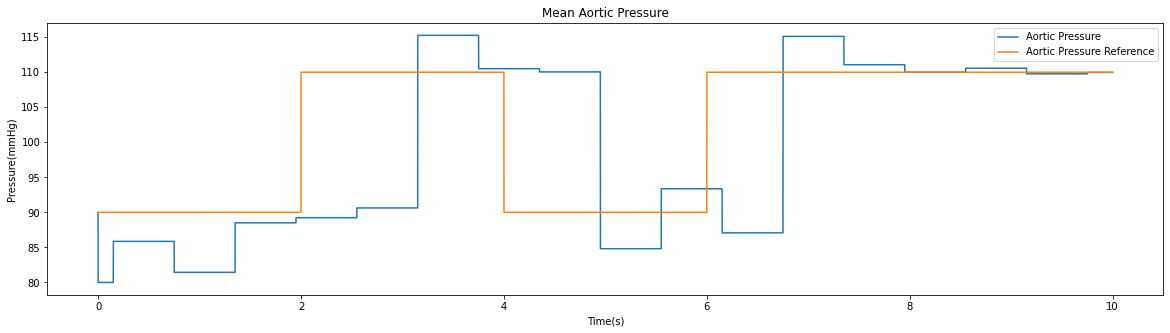

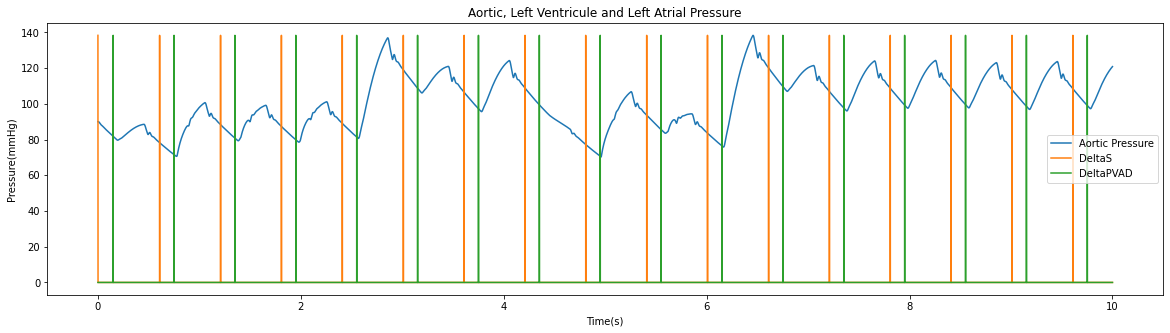

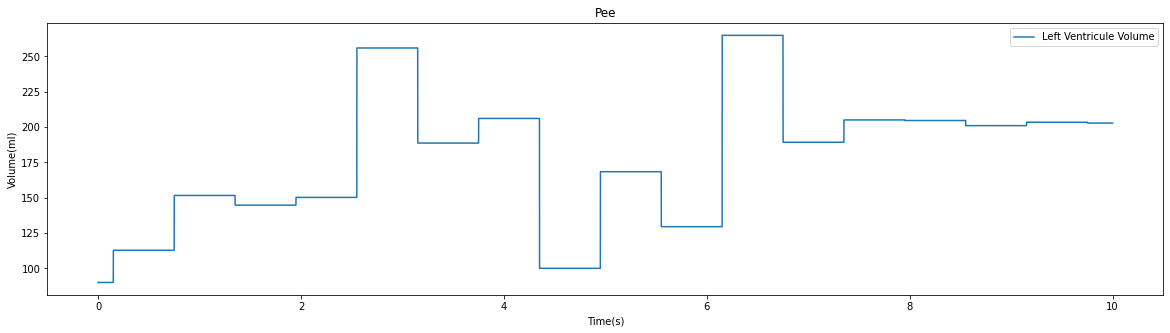

In [31]:
#PLOT VAD
import matplotlib.pyplot as plt

#plt.plot(model.T, vad.mPao_ref_v)
plt.figure(figsize=(20,5))
plt.xlabel('Time(s)')
plt.ylabel('Pressure(mmHg)')

plt.plot(model.T, vad.mPao_v, label='Aortic Pressure')
plt.plot(model.T, vad.mPao_ref_v, label='Aortic Pressure Reference')
plt.title('Mean Aortic Pressure')
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.xlabel('Time(s)')
plt.ylabel('Pressure(mmHg)')

plt.plot(model.T, model.Pao, label='Aortic Pressure')
plt.plot(model.T, np.dot(vad.deltaS,np.max(model.Pao)), label='DeltaS')
plt.plot(model.T, np.dot(vad.deltaPVAD,np.max(model.Pao)), label='DeltaPVAD')
plt.title('Aortic, Left Ventricule and Left Atrial Pressure')
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.xlabel('Time(s)')
plt.ylabel('Volume(ml)')

plt.plot(model.T, vad.Pee, label='Left Ventricule Volume')
plt.title('Pee')
plt.legend()
plt.show()

#plt.plot(model.Vve, vad.Ri)
#plt.title('Modelo de colapso ventricular; Resistência de entrada do DAV em função do volume ventricular')
#plt.show()

#plt.plot(model.Pao)
#plt.title('Modelo de colapso ventricular; Resistência de entrada do DAV em função do volume ventricular')
#plt.show()

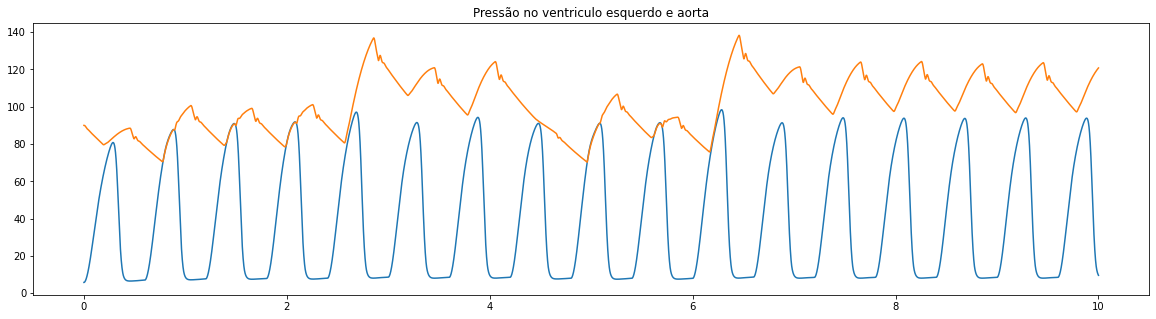

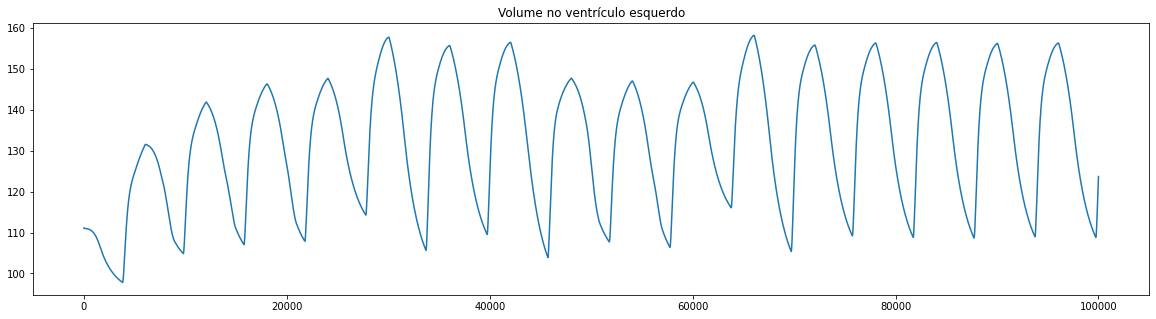

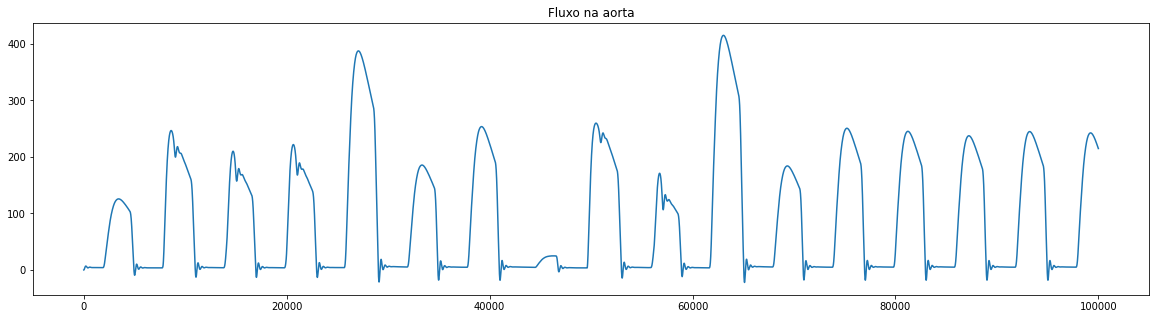

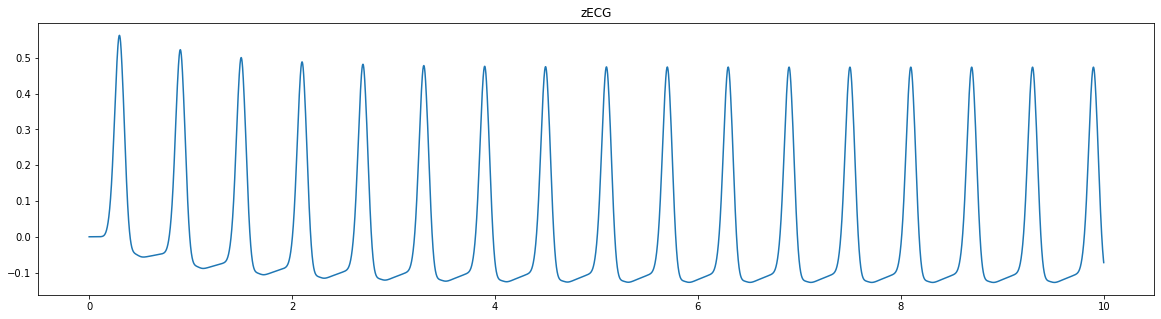

In [24]:
#PLOT

plt.figure(figsize=(20,5))
plt.plot(model.T, model.Pve)
plt.plot(model.T, model.Pao)
plt.title('Pressão no ventriculo esquerdo e aorta')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(model.Vve)
plt.title('Volume no ventrículo esquerdo')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(model.Qa)
plt.title('Fluxo na aorta')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(model.T, model.zECG)
plt.title('zECG')
plt.show()